# Image Classification Using Swin Transformer

Image_resolution = 224 x 224

patch_size = 4 x 4

number of features in one patch = 4 x 4 x 3 = 48

total number of patches in the whole image = 224/4 x 224/4 = 3136

In [1]:
# !pip install timm

In [2]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# torch.cuda.empty_cache()

In [5]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load the image file
# image_path = 'MHIST/images/MHIST_aaa.png'
image_path = './sorted_lc_image_sets/train/lung_aca/lungaca1.jpeg'

image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])


# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)


Tensor shape: torch.Size([1, 3, 224, 224])
Tensor data type: torch.float32


In [6]:
def window_partition(x, patch_size=4):
    """
    Args:
        x: (B, H, W, C)
        patch_size (int): patch size (Default: 4)
        
    Returns:
        patches: (num_patches * B, patch_size, patch_size, C)
                 (num_windows * B, patch_size, patch_size, C)
    """
    
    B, H, W, C = x.shape
    
    # Calculate the number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Convert to (B, num_patches_h, patch_size, num_patches_w, patch_size, C) 
    x = x.view(B, num_patches_h, patch_size, num_patches_w, patch_size, C)
    
    # Convert to (B, num_patches_h, num_patches_w, patch_size, patch_size, C)
    patches = x.permute(0, 1, 3, 2, 4, 5).contiguous()
    
    # Efficient Batch Computation - Convert to (B * num_patches_h * num_patches_w, patch_size, patch_size, C)
    patches = patches.view(-1, patch_size, patch_size, C)
    
    return patches


In [7]:
# Call the window_partition function on the tensor_image
window_size = 4
windows = window_partition(tensor_image, window_size)

num_patches, patch_size, _, _ = windows.shape

# Print the shape of the output windows
print("Windows shape:", windows.shape)

print("num_patches ",num_patches)

# Calculate the number of rows and columns in the grid
num_rows = int(num_patches ** 0.5)
num_cols = num_patches // num_rows

# Create a subplot grid
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the patches and plot them
# for i, ax in enumerate(axs.flat):
#     patch = windows[i].numpy()
#     ax.imshow(patch)
#     ax.axis("off")

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()


# (224/4 * 224/4 =56*56 = 3136 patches of size 4*4)

Windows shape: torch.Size([3136, 4, 4, 3])
num_patches  3136


# displaying all the patches (4*4) to visualize properly

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the windows tensor

# Iterate over the windows and display them
num_windows = windows.shape[0]
print("Total number of windows:", num_windows)
# for i in range(num_windows):
#     window = windows[i]  # Get a single window
    
#     # Convert the window tensor to a numpy array and transpose dimensions
#     window_np = window.numpy().transpose(1, 0, 2)
    
#     # Normalize the window values to [0, 1] range
#     window_np = (window_np - window_np.min()) / (window_np.max() - window_np.min())
    
#     # Display the window image
#     plt.imshow(window_np)
#     plt.axis('off')
#     plt.show()



Total number of windows: 3136


# Applying Linear Embedding

#### ( 4x4x3 tensor  to 1x1x96 tensor) 


In [9]:
# Lets use PatchEmbed

class PatchEmbed(nn.Module):
    """ Convert image to patch embedding
    
    Args:
        img_size (int): Image size (Default: 224)
        patch_size (int): Patch token size (Default: 4)
        in_channels (int): Number of input image channels (Default: 3)
        embed_dim (int): Number of linear projection output channels (Default: 96)
        norm_layer (nn.Module, optional): Normalization layer (Default: None)
    """
    
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size) # (img_size, img_size) to_2tuple simply convert t to (t,t)
        patch_size = to_2tuple(patch_size) # (patch_size, patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]] # (num_patches, num_patches)
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        
        # proj layer: (B, 3, 224, 224) -> (B, 96, 56, 56)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None
        
    def forward(self, x):
        """
        x: (B, C, H, W) Default: (B, 3, 224, 224)
        returns: (B, H//patch_size * W//patch_size, embed_dim) (B, 56*56, 96)
        """
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}]) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        # (B, 3, 224, 224) -> (B, 96, 56, 56)
        x = self.proj(x)
        
        # (B, 96, 56, 56) -> (B, 96, 56*56)
        x = x.flatten(2)
        
        # (B, 96, 56*56) -> (B, 56*56, 96): 56 refers to the number of patches
        x = x.transpose(1, 2)
        
        if self.norm is not None:
            x = self.norm(x)
        
        return x

# Applying patch embedding on  patches

In [10]:
# Load the image file
# image_path = 'MHIST/images/MHIST_aaa.png'
image_path = './sorted_lc_image_sets/train/lung_aca/lungaca1.jpeg'

image = Image.open(image_path)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()  # Convert the image to a tensor
])

# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

patch_embed = PatchEmbed(img_size=224, patch_size=4, in_chans=3, embed_dim=96)

embedding = patch_embed(tensor_image)


patches = patch_embed(tensor_image) 
# Print the shape of the output patches
print("Patches shape:", patches.shape)   # 96 is embedding dimension, 3136 patches 224/4 * 224/4

embedding

Patches shape: torch.Size([1, 3136, 96])


tensor([[[ 0.7499,  0.0261, -0.0041,  ...,  0.4006, -0.2320,  0.5881],
         [ 0.7066,  0.0089, -0.0025,  ...,  0.4144, -0.2193,  0.5886],
         [ 0.7220,  0.0473,  0.0063,  ...,  0.4137, -0.2100,  0.5609],
         ...,
         [ 0.5845,  0.0314,  0.0499,  ...,  0.4377, -0.1300,  0.5415],
         [ 0.5635,  0.0395,  0.0528,  ...,  0.4197, -0.1269,  0.5438],
         [ 0.5571,  0.0508,  0.0563,  ...,  0.4479, -0.1574,  0.5417]]],
       grad_fn=<TransposeBackward0>)

The output you are seeing is a tensor representing the embedded patches. Each element in the tensor corresponds to a patch in the image.

The output tensor you provided has the shape (1, 3136, 96), indicating that you have one image with 3136 patches, and each patch is represented by a 96-dimensional embedding vector.

# 1st patch embedding vector

In [11]:
print("First patch embedding vector:", patches[0, 0])

# 96 values in every patch because 96 is embedding dimension we mentioned above

#To access the second patch's embedding vector, you can use patches[0, 1]

First patch embedding vector: tensor([ 0.7499,  0.0261, -0.0041,  0.6489,  0.0903,  0.8984, -0.7820,  0.1747,
        -0.6738, -0.9686,  0.8260,  0.2337,  0.5202,  0.7631,  0.5975, -0.3903,
         0.0429,  0.2060, -0.6946,  0.3475, -0.0121, -0.1046,  0.3887,  0.2391,
        -1.0158, -0.5455,  0.1320,  0.0849,  0.3414,  0.3721, -0.2646,  0.1513,
        -0.2493,  0.4347, -0.8752,  0.7754,  0.3719, -0.3529, -0.0822,  0.7223,
        -0.2873, -0.1366,  0.3115,  0.9432,  0.0699,  0.3281,  0.5929, -1.4715,
        -0.6124,  0.2113, -0.8525,  1.4026, -0.0438,  0.1246, -0.3118, -1.0545,
         0.3545, -0.7576,  0.7968,  0.2013,  0.0379,  0.0638, -0.3047,  0.3066,
         0.4180,  0.4446, -0.0043,  0.1484, -0.0062, -0.6562,  0.1346, -0.3453,
         0.0213,  0.4539, -0.6577,  0.2498, -0.1960,  0.1452,  0.6379, -0.0251,
         0.0886,  0.2982,  0.5742, -0.1913,  0.4731,  0.1931, -0.5375, -0.4576,
        -0.2208, -0.4187, -0.2570, -0.5327, -0.1925,  0.4006, -0.2320,  0.5881],
       gr

# Using BasicLayer : Swin Transformer layer for one stage

In [12]:
from swin_functions_and_classes import *


stage_1 = BasicLayer(dim=96, input_resolution=(56, 56), depth=2, num_heads=4, window_size=7)

# Pass the patch embeddings through the BasicLayer
output = stage_1(embedding)
print(output.shape)
output


/opt/conda/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3136, 96])


tensor([[[-0.4953, -0.3004,  0.5684,  ..., -0.2557,  0.2185,  0.1350],
         [-0.5361, -0.3277,  0.5636,  ..., -0.2304,  0.2245,  0.1252],
         [-0.5330, -0.2595,  0.5765,  ..., -0.2251,  0.2500,  0.1191],
         ...,
         [-0.6701, -0.1282,  0.5845,  ..., -0.1233,  0.3008,  0.1283],
         [-0.6883, -0.1267,  0.5802,  ..., -0.1199,  0.2981,  0.1193],
         [-0.7236, -0.1145,  0.6076,  ..., -0.0949,  0.2756,  0.1269]]],
       grad_fn=<AddBackward0>)

# Patch Merging

##### USing patch merging on the embedding

In [13]:
# PatchMerging

# USing patch merging on the embedding
merge_layer = PatchMerging(input_resolution=(56, 56), dim=96, norm_layer=nn.LayerNorm)
merged_output = merge_layer(output)
print("Merged output shape:", merged_output.shape)    # (1, 28x28, 96*2) # (1, 784, 192)

Merged output shape: torch.Size([1, 784, 192])


In [14]:
batch_size = merged_output.shape[0]
num_patches = merged_output.shape[1]
num_channels = merged_output.shape[2]

print("Batch size:", batch_size)
print("Number of patches:", num_patches)
print("Number of channels:", num_channels)

Batch size: 1
Number of patches: 784
Number of channels: 192


the output width and height are both reduced by a factor of 2 and the number of output channels is 2C where C is the number of input channels, here for Swin-T, C=96 .


### Let's create Stage-1 of the Swin-T architecture using SwinTransformerBlock:

Using SwinTransformerBlock class on the patch embedding embedding

In [15]:
# Create an instance of the SwinTransformerBlock class with the desired parameters
block_1 = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=0,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


#  shift_size is set to 3
block_1_shf = SwinTransformerBlock(dim=96, input_resolution=(56, 56), num_heads=4, window_size=7, shift_size=2,
                             mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop=0.0, attn_drop=0.0,
                             drop_path=0.0, act_layer=nn.GELU, norm_layer=nn.LayerNorm)


# Pass the embedding through the SwinTransformerBlock:
output = block_1(embedding)
output_shf = block_1_shf(embedding)

print(output.shape)
print(output_shf.shape)
print(output)
print(output_shf)

torch.Size([1, 3136, 96])
torch.Size([1, 3136, 96])
tensor([[[ 0.3362,  0.3255,  0.3272,  ..., -0.3662, -0.3633,  0.5226],
         [ 0.2924,  0.2953,  0.3195,  ..., -0.3457, -0.3578,  0.5146],
         [ 0.3130,  0.3316,  0.3341,  ..., -0.3626, -0.3418,  0.5042],
         ...,
         [ 0.1902,  0.2587,  0.3579,  ..., -0.3197, -0.2751,  0.5108],
         [ 0.1772,  0.2627,  0.3474,  ..., -0.3290, -0.2720,  0.5128],
         [ 0.1672,  0.2780,  0.3494,  ..., -0.2992, -0.2995,  0.5133]]],
       grad_fn=<AddBackward0>)
tensor([[[ 1.4332, -0.3181, -0.2185,  ...,  0.3306, -0.4879,  0.9909],
         [ 1.3876, -0.3435, -0.2229,  ...,  0.3534, -0.4664,  0.9844],
         [ 1.4174, -0.3092, -0.2236,  ...,  0.3557, -0.4625,  0.9905],
         ...,
         [ 1.2807, -0.3495, -0.2079,  ...,  0.3843, -0.3790,  0.9845],
         [ 1.2573, -0.3428, -0.2088,  ...,  0.3746, -0.3765,  0.9879],
         [ 1.2555, -0.3255, -0.2078,  ...,  0.3923, -0.4112,  0.9862]]],
       grad_fn=<AddBackward0>)


# SwinTransformer :

In [16]:
model = SwinTransformer()

print(tensor_image.shape)

model(tensor_image).shape

torch.Size([1, 3, 224, 224])


torch.Size([1, 1000])

a tensor_image tensor  (1, 3, 224, 224), which represents a batch of 1 images with 3 channels and size 224x224.

1000 is the number of classes for the classification head.

torch.Size([1, 1000]) represents the shape of the output tensor when passing tensor_image through the model. In this case, it has a batch size of 1 and 1000 output dimensions, which matches the number of classes specified by num_classes.

# Now, Let's work with custom dataset

In [17]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Concatenate the current directory with additional directories
# train_dir = os.path.join(current_directory, "MHIST", "train")
# test_dir = os.path.join(current_directory, "MHIST", "test")

train_dir = os.path.join(current_directory, "sorted_lc_image_sets", "train")
test_dir = os.path.join(current_directory, "sorted_lc_image_sets", "test")

# print(path)


# Create Datasets and DataLoaders

In [18]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [19]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

# Create augmeneted transform pipeline manually
augmentation_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])
print(f"Augmented transforms: {augmentation_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
Augmented transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
)


In [20]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=augmentation_transforms,
    test_transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f669022e7f0>,
 ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'])

torch.Size([3, 224, 224]) tensor(4)


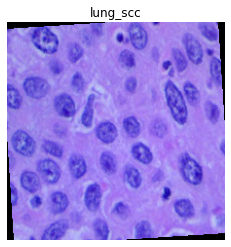

In [21]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [22]:
model = SwinTransformer(num_classes=len(class_names))

In [23]:
"""
Contains functions for training and testing a PyTorch model.
"""
# import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    y_pred_list = []
    y_true_list = []
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
            y_pred_list = np.append(y_pred_list, test_pred_labels.cpu().numpy())
            y_true_list = np.append(y_true_list, y.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    # Calculate and accumulate precision, recall, and F1 metrics
#     precision = Precision(num_classes=test_pred_labels.shape[1]).to(device)
#     recall = Recall(num_classes=test_pred_labels.shape[1]).to(device)
#     f1 = F1(num_classes=test_pred_labels.shape[1]).to(device)
#     precision.update(test_pred_labels, y)
#     recall.update(test_pred_labels, y)
#     f1.update(test_pred_labels, y)

#     test_precision = precision.compute().item()


#     test_recall = recall.compute().item()
#     test_f1 = f1.compute().item()
    
#     print(type(y_true_list[0]))
#     print(type(y_pred_list[0]))
    print(classification_report(y_true_list, y_pred_list, zero_division=1, digits = 4))
    
    test_precision = precision_score(y_true_list, y_pred_list, average='weighted', labels=np.unique(y_pred_list))
    test_recall = recall_score(y_true_list, y_pred_list, average='weighted', labels=np.unique(y_pred_list))
    test_f1 = f1_score(y_true_list, y_pred_list, average='weighted', labels=np.unique(y_pred_list))
    
    return test_loss, test_acc, test_precision, test_recall, test_f1

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    results["test_precision"] = []
    results["test_recall"] = []
    results["test_f1"] = []
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc, test_precision, test_recall, test_f1 = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"test Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"test_precision: {test_precision:.4f} | "
          f"test_recall: {test_recall:.4f} | "
          f"test_f1: {test_f1:.4f} | " 
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)

    # Return the filled results at the end of the epochs
    return results


In [24]:
# from going_modular.going_modular import engine
from helper_functions import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
# optimizer = torch.optim.Adam(params=model.parameters(), 
#                              lr=1e-4, # Base LR from Table 3 for ViT-* ImageNet-1k
#                              betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
#                              weight_decay=0) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-4, momentum=0.9, nesterov=True)
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-4, momentum=0.9)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0     0.8064    0.5540    0.6568      1000
         1.0     0.6075    0.9210    0.7321      1000
         2.0     0.7551    0.4040    0.5264      1000
         3.0     1.0000    0.7670    0.8681      1000
         4.0     0.6134    0.9170    0.7351      1000

    accuracy                         0.7126      5000
   macro avg     0.7565    0.7126    0.7037      5000
weighted avg     0.7565    0.7126    0.7037      5000

test Epoch: 1 | train_loss: 0.8193 | train_acc: 0.6401 | test_loss: 0.6730 | test_acc: 0.7134 | test_precision: 0.7565 | test_recall: 0.7126 | test_f1: 0.7037 | 
              precision    recall  f1-score   support

         0.0     0.6955    0.7150    0.7051      1000
         1.0     0.6835    0.7320    0.7069      1000
         2.0     0.7736    0.5330    0.6311      1000
         3.0     1.0000    0.8720    0.9316      1000
         4.0     0.6664    0.8930    0.7632      1000

    accuracy           

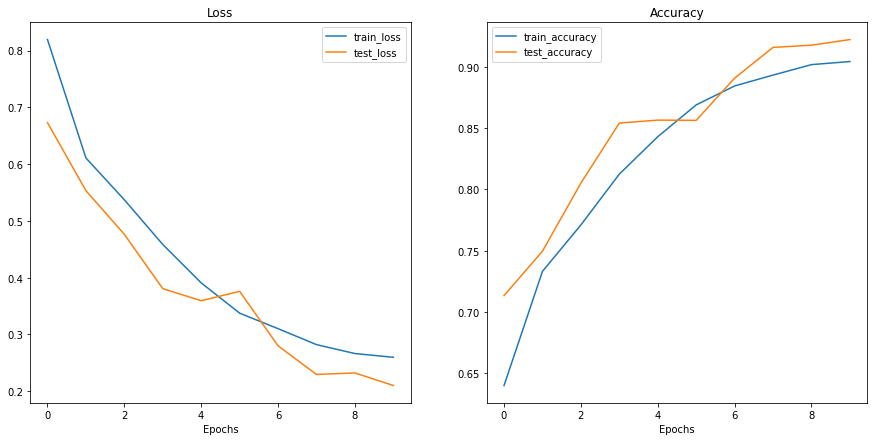

In [25]:
# To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

# Prediction

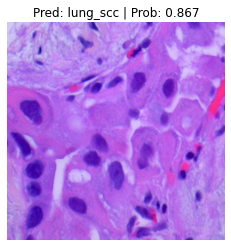

In [26]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
# custom_image_path = "MHIST/test/SSA/MHIST_aaz.png"
custom_image_path = './sorted_lc_image_sets/train/lung_aca/lungaca1.jpeg'

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)